# This document presents two PageRank algorithms
1. A general PageRank
2. A topic sensitive PageRank

---
### **Algorithm 1** : A general PageRank algorithm - Set up the algorithm
The PageRank equation is given as $$r_j = \sum_{i\rightarrow j}\beta\frac{r_i}{d_i} + (1-\beta)\frac{1}{n}$$
where $n$ is the total number of nodes in the web, $r_i$ is the PageRank of the incoming node $i$ and $d_i$ is the out-degree of node $i$.

💡Remark : $\sum_i r_i = 1$

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def page_rank(G, beta=0.8, max_iter=100, tol=1e-6):
    # Initialize the PageRank vector
    n = G.number_of_nodes()        # int : total number of nodes in the graph
    pr = np.ones(n) / n            # numpy array : [1/n,1/n,...,1/n]
    nodes = list(G.nodes())        # list: NodeView eg., [1,2,3,4,5] node 1, 2, 3,...
    
    for _ in range(max_iter):
        prev_pr = pr.copy()      
        # At the beginning of each iteration, the current PageRank scores are copied to prev_pr. 
        # This allows us to compare the scores after the update to check for convergence.
        
        for i, node in enumerate(nodes):  
            incoming_links = G.in_edges(node)  # eg., G.in_edges(4) -> InEdgeDataView([(2, 4), (3, 4), (1, 4)])
            pr[i] = ((1 - beta) / n) + beta * sum(prev_pr[j] / G.out_degree(j) for j, _ in incoming_links if G.out_degree(j) > 0)
            # if G.out_degree(j) > 0: This condition ensures that we only consider nodes that have outgoing edges to prevent division by zero.
        
        # Check for convergence
        if np.linalg.norm(pr - prev_pr, 1) < tol: # L1 norm < 1e-6
            break

    # Normalization
    total_score = sum(pr)
    pr = pr / total_score
    
    return dict(zip(nodes, pr))

#### Draw a graph

In [2]:
def draw_graph(G, pagerank_scores):
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10)
    
    # Draw node sizes based on PageRank scores
    node_sizes = [5000 * pagerank_scores[node] for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue', alpha=0.8)
    
    plt.title("Graph Visualization with PageRank Scores")
    plt.show()

#### Example - General PageRank

PageRank Scores: {1: 0.1840277375379401, 2: 0.3067132178151349, 3: 0.1446755905940787, 4: 0.3645834540528464}
----------------------------------------------------------------------------------------------------


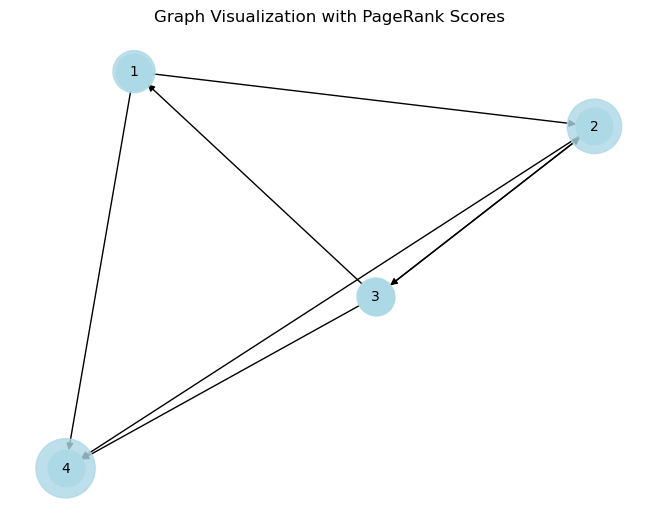

In [3]:
G = nx.DiGraph()
G.add_edges_from([(1, 2), (2, 3), (3, 1), (2, 4), (3, 4), (1, 4), (3, 2)])
pagerank_scores = page_rank(G)
print("PageRank Scores:", pagerank_scores)
print('-'*100)

draw_graph(G, pagerank_scores)

In [4]:
total_score1 = sum(pagerank_scores.values())
total_score1

1.0

### **Algorithm 2** : A topic sensitive PageRank algorithm - Set up the algorithm
Let $S$ be a collection of integers that represent the row and column numbers of the pages identified as related to a specific topic, known as the teleport set, then the topic sensitive PageRank for $S$ is the limit of the iteration
$$r_j=\sum_{i\rightarrow j}\beta\frac{r_i}{d_i} + (1-\beta)[e_S/|S|]_j$$
where $e_S$ is the vector that has $1$ in the components in $S$ and $0$ in the other components, $|S|$ is the size of set $S$ and $[\cdot]_j$ is the $j$-th element of the vector. Or equavilently,
$$r=\beta Mr + (1-\beta)e_S/|S|$$

💡Remark : $\sum_i r_i = 1$.

In [5]:
def topic_sensitive_page_rank(G, S, beta=0.85, max_iter=100, tol=1e-6):
    n = G.number_of_nodes()
    pr = np.zeros(n)
    nodes = list(G.nodes())
    size_S = len(S)
    
    # Create a vector for e_S
    e_S = np.zeros(n)
    for node in S:
        if node in nodes:
            e_S[nodes.index(node)] = 1  # Set 1 for nodes in S

    for _ in range(max_iter):
        prev_pr = pr.copy()

        # Update PageRank scores
        for j in range(n):
            incoming_links = G.in_edges(nodes[j])
            sum_incoming = sum(prev_pr[nodes.index(i)] / G.out_degree(i) 
                               for i, _ in incoming_links if G.out_degree(i) > 0)

            # Contribution from teleport set
            teleport_contribution = (1 - beta) * (e_S[j] / size_S if size_S > 0 else 0)
            
            pr[j] = beta * sum_incoming + teleport_contribution

        # Check for convergence
        if np.linalg.norm(pr - prev_pr, 1) < tol:
            break

    # Normalization
    total_score = sum(pr)
    pr = pr / total_score
    
    return dict(zip(nodes, pr))

#### Example - Topic Sensitive PageRank

Topic-Sensitive PageRank Scores: {'A': 0.16624151288263966, 'B': 0.2057075733126847, 'C': 0.39115682730869117, 'D': 0.0706525736133447, 'E': 0.16624151288263966, 'F': 0.0}
------------------------------------------------------------------------------------------------------------------------------------------------------


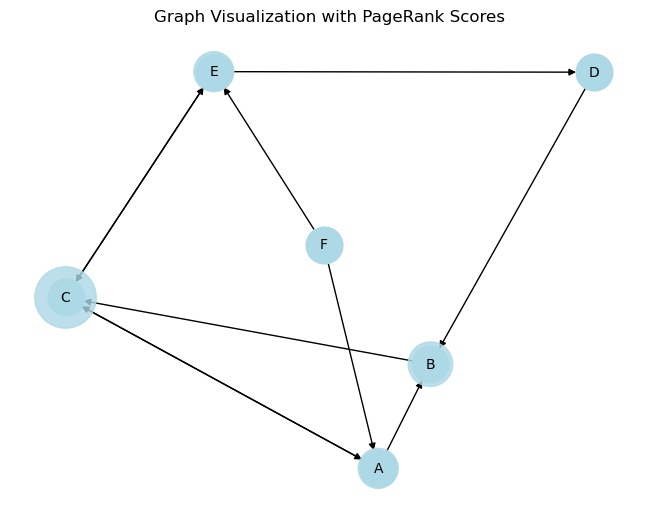

In [6]:
# Topic-Sensitive PageRank
G = nx.DiGraph()
edges = [('A', 'B'), ('A', 'C'), ('B', 'C'), ('C', 'A'), ('D', 'B'), ('E', 'D'), ('F', 'A'), ('F', 'E'), ('E', 'C'), ('C', 'E')]
edges1 = [(1, 2), (3, 1), (2, 5), (4, 3), (4, 5), (5, 2), (2, 1)]
G.add_edges_from(edges)

# Define the teleport set
teleport_set = ['B', 'C']  # Nodes related to a specific topic

# Calculate PageRank based on the teleport set
pagerank_scores = topic_sensitive_page_rank(G, teleport_set)
print("Topic-Sensitive PageRank Scores:", pagerank_scores)
print('-'*150)
draw_graph(G, pagerank_scores)

In [7]:
total_score2 = sum(pagerank_scores.values())
total_score2

0.9999999999999999